# TEXT to SQL: Using ML to generate structured queries from Natural Language

Capstone Project by Alberto Marengo

NOTE: This is Jupyter Notebook 1 of 6 for this project.

<span style="font-size:larger;">**Can AI read a Natural Language Query and translate it into a Database Query?**

This question is what this project is trying to answer. Can someone with zero knowledge of the SQL language still get the insight they want from with dataset, with some "help"?

To try to aswer this question we have used the WikiSQL dataset.

[WikiSQL](https://github.com/salesforce/WikiSQL) is a crowd-sourced dataset of ~56,000 hand-annotated examples of questions and SQL queries distributed across ~24,000 tables from Wikipedia. Namely, WikiSQL is the largest hand-annotated semantic parsing dataset to date - it is an order of magnitude larger than other datasets that have logical forms, either in terms of the number of examples or the number of tables.

The dataset files are in two formats: jsonl and db format. The former can be read line by line, where each line is a serialized JSON object. The latter is a SQLite3 database.

Question, query and table ID
These files are contained in the *.jsonl files. A line looks like the following:
`
{
   "phase":1,
   "question":"who is the manufacturer for the order year 1998?",
   "sql":{
      "conds":[
         [
            0,
            0,
            "1998"
         ]
      ],
      "sel":1,
      "agg":0
   },
   "table_id":"1-10007452-3"
}
`

The fields represent the following:

* phase: the phase in which the dataset was collected. We collected WikiSQL in two phases.
* question: the natural language question written by the worker.
* table_id: the ID of the table to which this question is addressed.
* sql: the SQL query corresponding to the question. This has the following subfields:
    * sel: the numerical index of the column that is being selected. Operators are:
        * 0 - no aggregation
        * 1 - MAX
        * 2 - MIN
        * 3 - COUNT
        * 4 - SUM
        * 5 - AVG
    * agg: the numerical index of the aggregation operator that is being used. You can find the actual operator from Query.agg_ops in lib/query.py.
    * conds: a list of triplets (column_index, operator_index, condition) where:
        * column_index: the numerical index of the condition column that is being used. You can find the actual column from the table.
        * operator_index: the numerical index of the condition operator that is being used. The operators are:
            * 0 - =
            * 1 - >
            * 2 - <
        * condition: the comparison value for the condition, in either string or float type.
        

The dataset comes already split into three `json` files: train, test and dev (validation). Each set also comes with the database as `.jsonl` and `.db` (sqlite3). In order to visualize the database and the tables in `MySQL Workbench` we used [ESF Database Migration Toolkit](https://www.dbsofts.com/).
                     
Below is a screengrab of the wikiSQL `train` dataset loaded into `MySQL Workbench`. On the left the list of the tables, on the right an example of one of the tables.
                     
<img src='figures/wikisql schema.jpg' width=1000 height=1000/>
    


        
Let's load the libraries and the train data and have a look at it into a Pandas DataFrame.

# The Dataset

In [1]:
import pandas as pd
from load.load_dataset import CreateData
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [3]:
data = []
with open('data/train.jsonl') as f:
    for line in f:
        data.append(json.loads(line))
df = pd.DataFrame(data)
df.head()

,phase,table_id,question,sql
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']], 'agg': 0}"
1,1,1-1000181-1,What is the current series where the new series began in June 2011?,"{'sel': 4, 'conds': [[5, 0, 'New series began in June 2011']], 'agg': 0}"
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']], 'agg': 0}"
3,1,1-1000181-1,Name the background colour for the Australian Capital Territory,"{'sel': 1, 'conds': [[0, 0, 'Australian Capital Territory']], 'agg': 0}"
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}"


In [4]:
df.shape

(56355, 4)

Above is how the "raw" train dataset, loaded into a Pandas DataFrame looks like. The train set contains 56,355 entries and below is how the encoding works (for the first row):

<span style="font-size:larger;">**Example Question**

Tell me what the notes are for South Australia

<span style="font-size:larger;">**Encoded Query**

SELECT column 5\
FROM 1-1000181-1\
WHERE column 3 = "SOUTH AUSTRALIA";


Given the way the dataset is encoded, we are facing a Multi-output multi-class classification problem. The input of the model will be the tokenized (or vectorized) $question$ and the outputs will be the $5 columns$ (each one with multiple classes).

### CreateData Class

Because we are going to need to do the same operations on all three files (train, test and val) we have create a Class called `CreateData` that can be loaded from the python file `load_dataset`. 

The class is initialized with the path to the file we want to load. Once the instance is created, the manipulated DataFrame contains the unpacked sql query as following:

* `table_id`: the table to query
* `question`: the original English question
* `select_col`: column number to SELECT
* `agg_col`: operator for GROUP BY
* `first_where_col_0`: column number for WHERE statement
* `first_where_col_1`: operator WHERE statement
* `first_where_col_2`: condition WHERE statement

* `second_where_col_0`: column number for second WHERE statement
* `second_where_col_1`: operator second WHERE statement
* `second_where_col_2`: condition second WHERE statement

This last column is either a float or a string. Given the huge number of unique values this column can have, to simplify the problem, the "EntityRecognizer" from the (spaCy)[https://spacy.io/api/entityrecognizer] was use to reshape the data to a reasonable number of classes. The assumption for the condition column was that the question would contain an entity that the WHERE statement was referring to for the data filtering. Possible entities are numbers, organizations, countries, cities, etc..

Only few rows contain multiple WHERE statement and in order to simplify the problem we are later going to drop these three columns which will contain mostly `Nan` values.

The following attributes can be called upon data loading:

* `.df` to have a look at the loaded dataset. 
* `.entity_list` to retrieve the list of entities recognized into the condition column

The following methods can be called upon data loading:

* `.plot` to see the class distribution of the 5 columns
* `.reduce_return_x_y()` to create the X and y (features and target) data files. X contains the `question` column, y contains the 5 column we want to predict. A list of how many classes to keep for each column can be passed in order to reduce the number of classes to predict. Default is `None` were all the classes are kept. If only some of the columns want to be re-sized, `all` can be passed to the columns to keep all the classes.

Let's call the class on the three files and explore the data.

## Extracting the data

Let's start loading the train dataset.

### Train Data

In [5]:
train = CreateData('data/train.jsonl')

Loaded dataset shape: (56355, 10)
Instance created!! Database is loaded! 
 Call .df to see it. 
 Call .entity_list to retrieve the entity converter list. 
 Call .plot() for class distribution! 
 Call .reduce_return_x_y() to make X and y!


Once the `train` instance is created, the message let us know the the data is loaded. The DataFrame has 56,355 rows and 10 columns. It also tells us the different method we can call.

Let's have a look at the first 5 rows.

In [6]:
train.df.head(5)

,table_id,question,select_col,agg_col,first_where_col_0,first_where_col_1,first_where_col_2,second_where_col_0,second_where_col_1,second_where_col_2
0,1-1000181-1,Tell me what the notes are for South Australia,5,0,3.0,0.0,9,NaN,NaN,NaN
1,1-1000181-1,What is the current series where the new series began in June 2011?,4,0,5.0,0.0,2,NaN,NaN,NaN
2,1-1000181-1,What is the format for South Australia?,2,0,0.0,0.0,9,NaN,NaN,NaN
3,1-1000181-1,Name the background colour for the Australian Capital Territory,1,0,0.0,0.0,3,NaN,NaN,NaN
4,1-10007452-3,how many times is the fuel propulsion is cng?,3,3,5.0,0.0,1,NaN,NaN,NaN


We can also have a look at the entities recognize in the condition column of the WHERE statement and save it to the drive as a `json` file. It will be useful to have this list when we are making predictions and we want to decode the query.

In [7]:
train.entity_list

{0: 'CARDINAL',
 1: 'empty',
 2: 'DATE',
 3: 'ORG',
 4: 'PERSON',
 5: 'GPE',
 6: 'ORDINAL',
 7: 'NORP',
 8: 'FAC',
 9: 'LOC',
 10: 'MONEY',
 11: 'WORK_OF_ART',
 12: 'PERCENT',
 13: 'TIME',
 14: 'PRODUCT',
 15: 'QUANTITY',
 16: 'EVENT',
 17: 'LANGUAGE',
 18: 'LAW'}

In [8]:
with open('processed_data/entity_conversion.json', 'w') as fp:
    json.dump(train.entity_list, fp)

The list is ordered by the count of the values. The most popular entity in the questions is `CARDINAL` which represents numbers. The second is `empty`, unfortunately, meaning that no entity was found, followed by `DATE`, `ORG` (organization), `PERSON` and so on.

Let's have a look at the class distribution in the 5 columns.

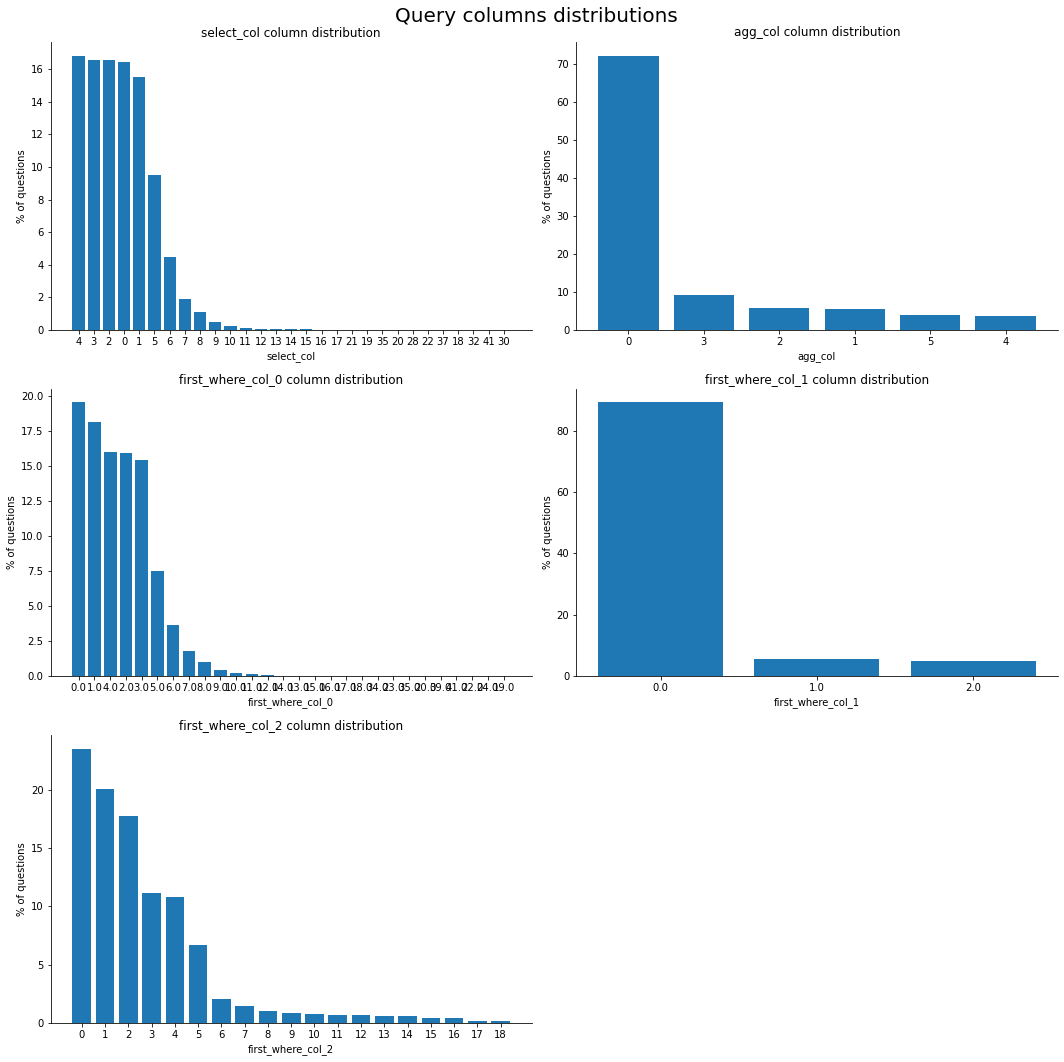

In [9]:
train.plot()

All the columns present really imbalanced classes. Furthermore, looking at the `SELECT` and `WHERE` (first and last) columns we are in the presence of too many classes. Because we are going to be using a classifier we want to reduce the class number, grouping the less frequent ones into one. This is another approximation that is necessary to check the performance of a preliminary model. Once we are sure that the model is performing well enough we can then try to leave all the classes. 

That's why the method `reduce_return_x_y` has the capability to reduce or keep the classes. For this first attempt we are going to reduce 
* `select_col` to 10 classes
* `first_where_col_0` to 11 classes
* `first_where_col_2` to 10 classes

We will keep all the classes in the other two columns.

During this operation we are also going to create the X and y files that are going to be the features and targets for our model.

In [10]:
X_train, y_train = train.reduce_return_x_y(keep_list=[10, 'all', 11, 'all', 10])

X shape: (55932,)
y shape: (55932, 5)


Let's plot again the DataFrame to see the result of the **class reduction**.


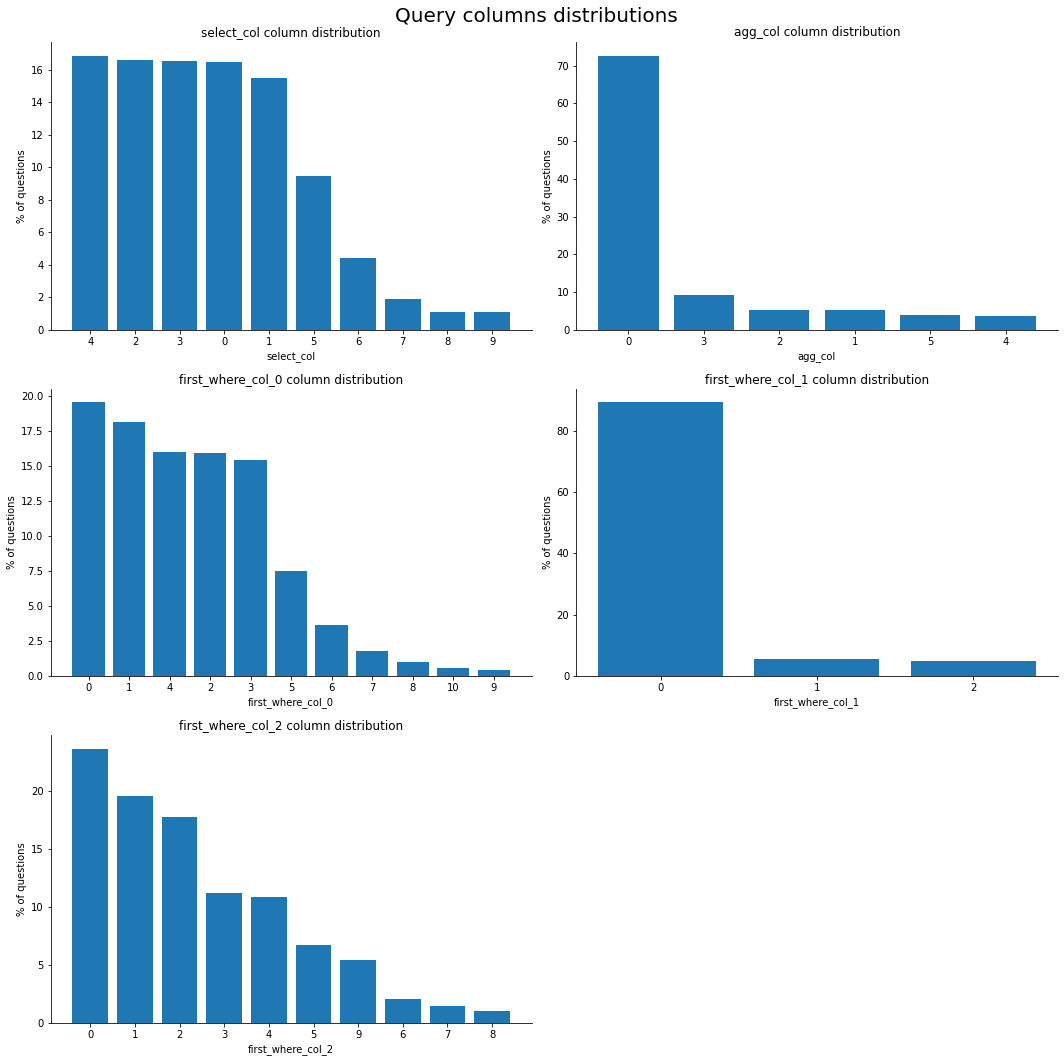

In [11]:
train.plot()

In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (55932,)
y_train shape: (55932, 5)


X_train has 55,932 questions (one column)

y_train has 55,932 rows and 5 columns (targets).

The number of rows is slightly smaller because some of the queries didn't have any WHERE clause. Again, for simplicity, at this stage we have decided to drop these rows to make our life "easier".

Lastly we are going to save X_train and y_train to file as `.csv` files in order to easily load it in the following notebooks.

In [13]:
X_train.to_csv('processed_data/X_train.csv')
y_train.to_csv('processed_data/y_train.csv')

We are now going to repeat the same operation on the `validation` and `test` sets, paying attention on reducing the classes to the same size we did on the train set.

## Validation Data

We create the val instance and plot the class distribution.

In [14]:
val = CreateData('data/dev.jsonl')

Loaded dataset shape: (8421, 10)
Instance created!! Database is loaded! 
 Call .df to see it. 
 Call .entity_list to retrieve the entity converter list. 
 Call .plot() for class distribution! 
 Call .reduce_return_x_y() to make X and y!


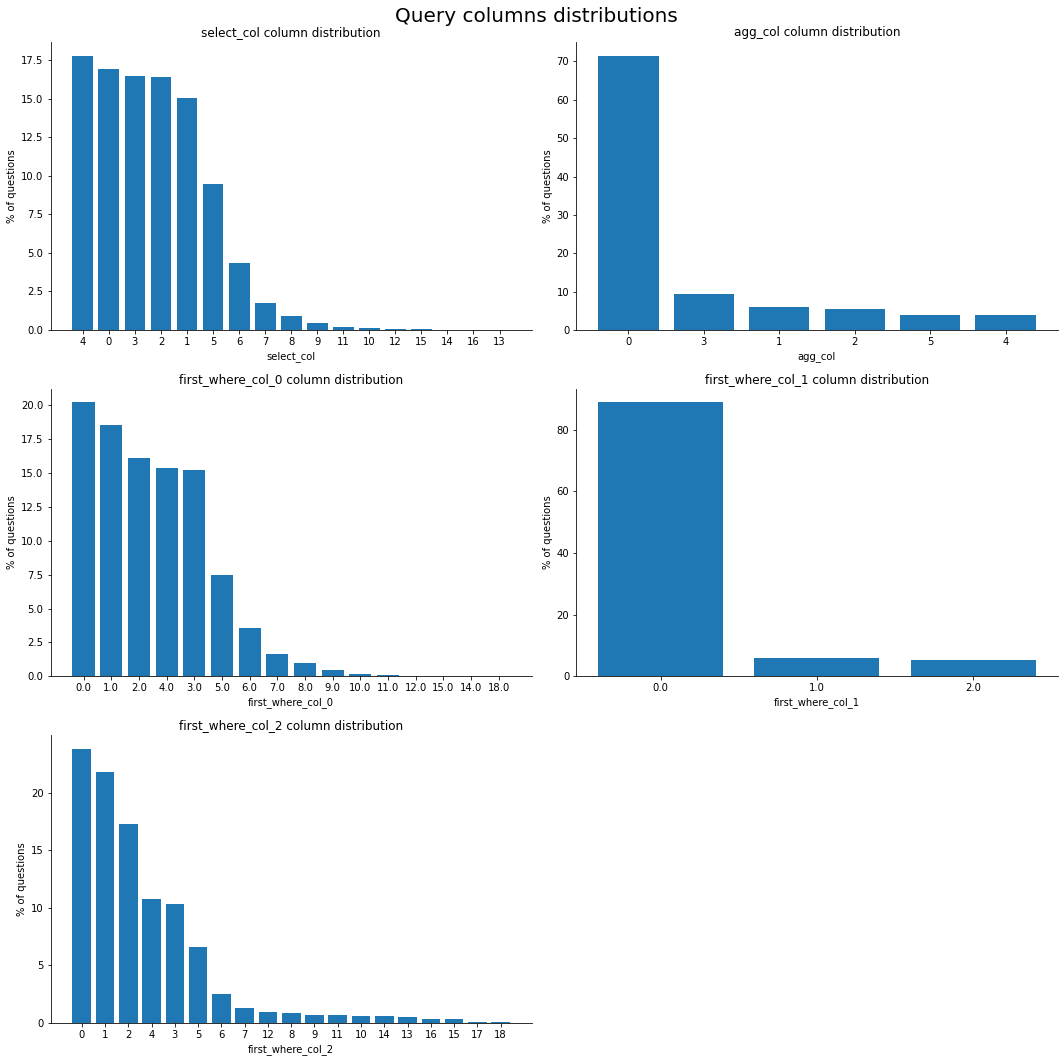

In [15]:
val.plot()

We reduce the classes of `SELECT` and `WHERE` (first and last only) and create X_val and y_val.

We plot it to make sure we made the changes.

In [16]:
X_val, y_val = val.reduce_return_x_y(keep_list=[10, 'all', 11, 'all', 10])

X shape: (8357,)
y shape: (8357, 5)


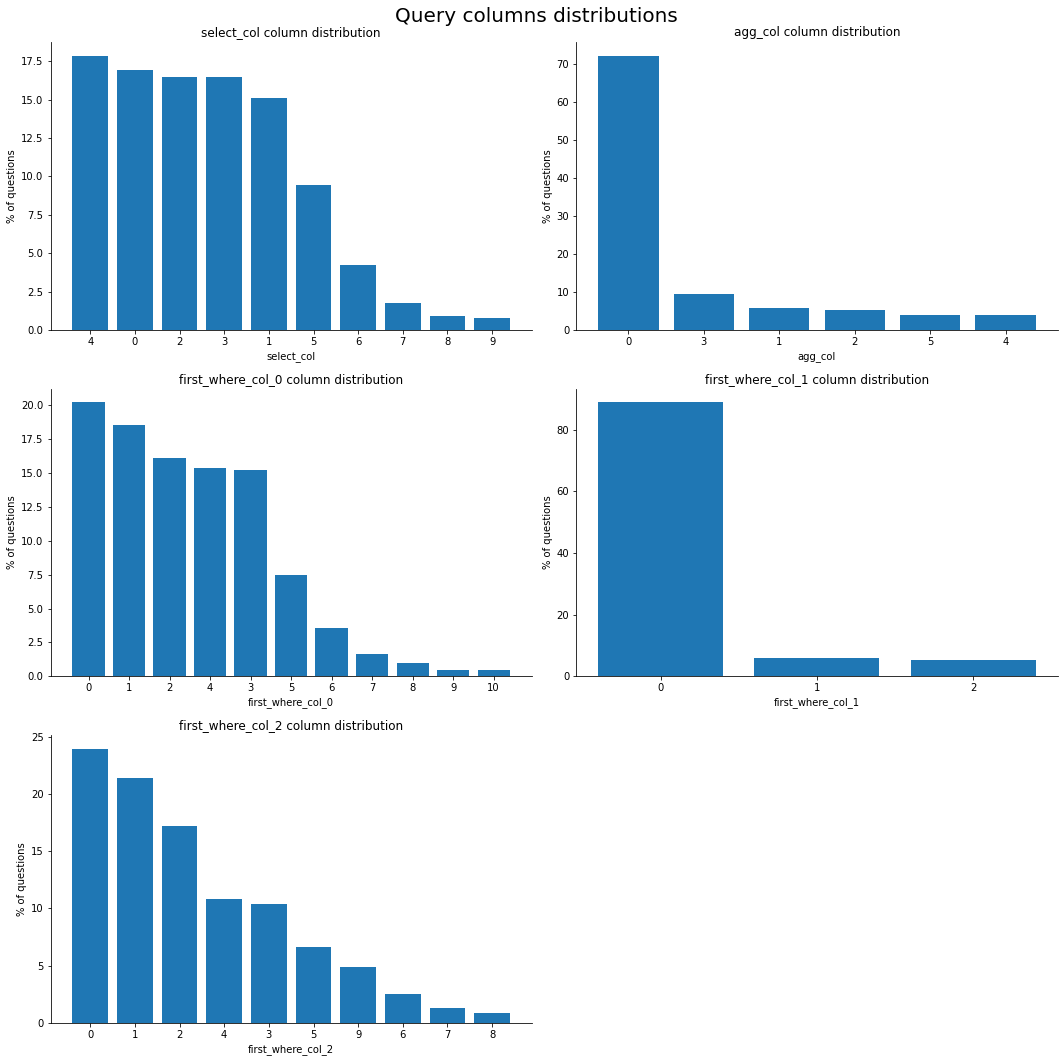

In [17]:
val.plot()

We then save the files to the drive as `.csv`.

In [18]:
X_val.to_csv('processed_data/X_val.csv')
y_val.to_csv('processed_data/y_val.csv')

## Test Data

Finally, we do the same with the `test` set. 

We create a test instance and plot the class distribution for the 5 columns.

In [19]:
test = CreateData('data/test.jsonl')

Loaded dataset shape: (15878, 10)
Instance created!! Database is loaded! 
 Call .df to see it. 
 Call .entity_list to retrieve the entity converter list. 
 Call .plot() for class distribution! 
 Call .reduce_return_x_y() to make X and y!


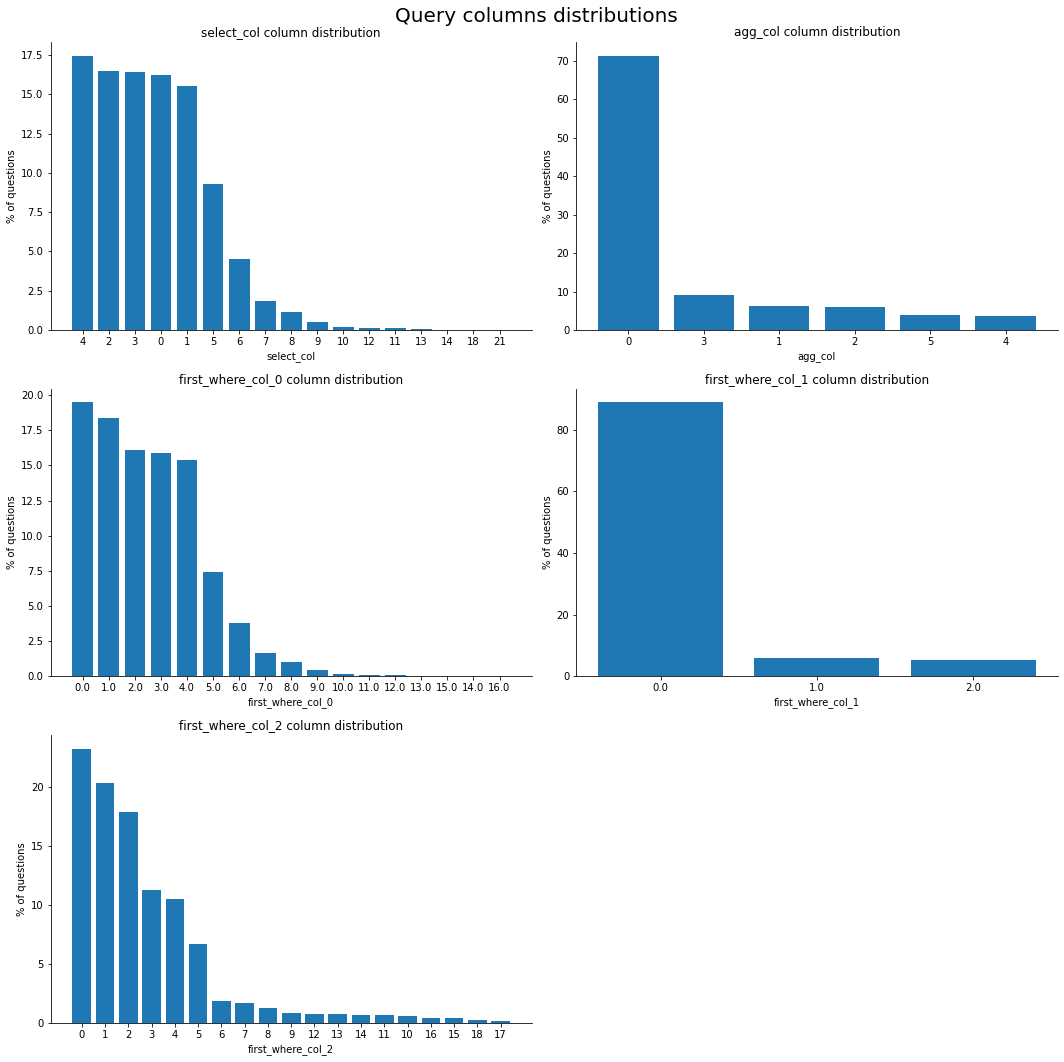

In [20]:
test.plot()

We reduce the classes, create X_test and y_test and plot the data.

In [21]:
X_test, y_test = test.reduce_return_x_y(keep_list=[10, 'all', 11, 'all', 10])

X shape: (15747,)
y shape: (15747, 5)


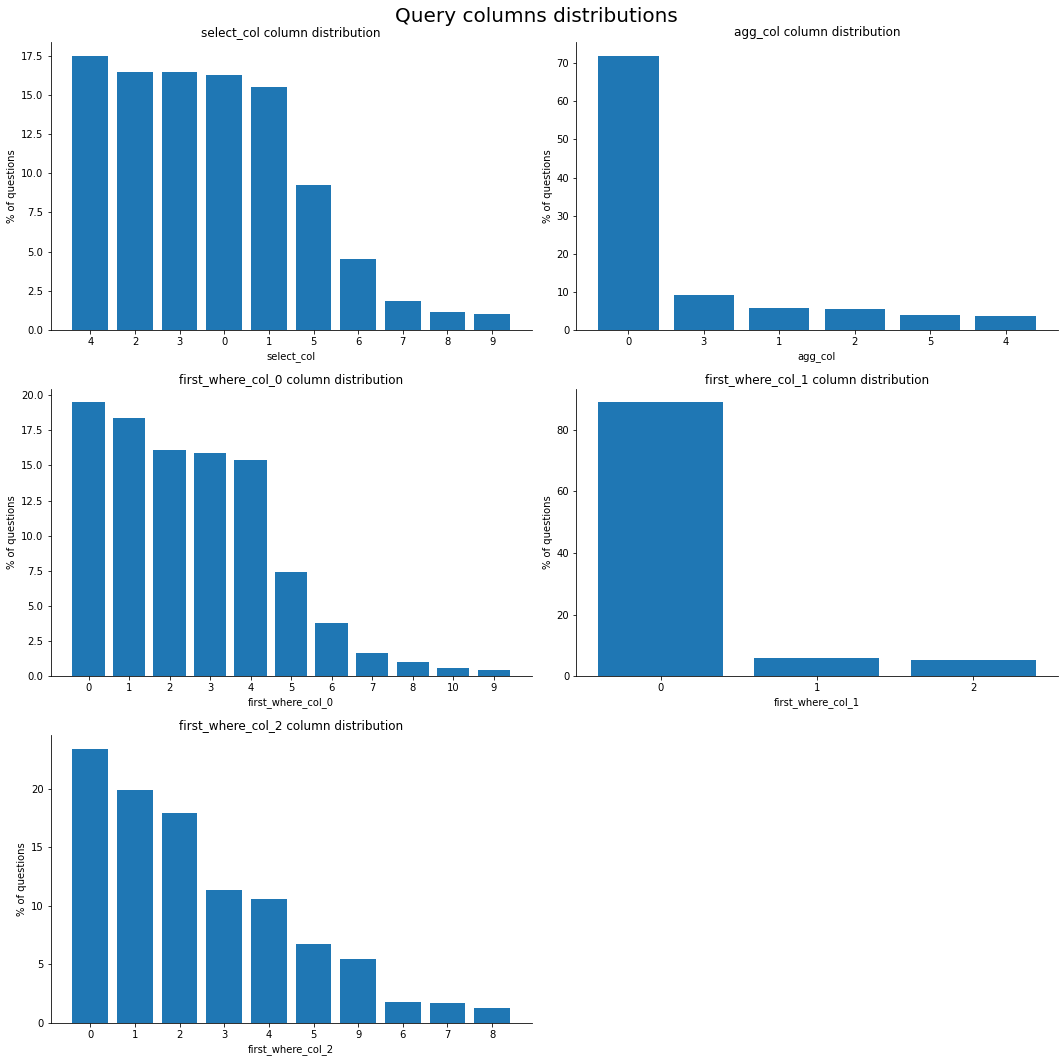

In [22]:
test.plot()

Lastly we save the files to the drive as `.csv`.

In [23]:
X_test.to_csv('processed_data/X_test.csv')
y_test.to_csv('processed_data/y_test.csv')

This is the end of Jupyter Notebook 1 of 6. In the next one we'll perform some Explanatory Data Analysis (EDA) and Natural Language Processing (NLP) in order to get more insights about the dataset.